In [1]:
import torch
import torch.nn as nn
import numpy as np
import random                                                                  
import matplotlib.pyplot as plt
torch.backends.cudnn.deterministic=True
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import math
from torch.autograd import grad
from Libraries import robotarm as ra
from Libraries import ICNN_net as net
from Libraries import ICNN_plot as pl
from Libraries import ICNN_optim as opt
dtype = torch.float
device_c = torch.device("cpu")
device = torch.device("cuda:1")

In [2]:
#robot initialize
l1 = 3 
l2 = 2
m1 = 3
m2 = 4
robot = ra.robotarm(l1,l2,m1,m2,device)
xinit = torch.tensor([[-3],[0]],dtype=dtype)
xfinal = torch.tensor([[3],[2.5]],dtype=dtype)
T = 5
delta = 0.6
num_timesteps = 100
rmin,rmax,qmin,qmax,dt,qinit,qfinal,Xstable,xtraj,x_dot,qtraj,q_dot = robot.Initialize(xinit,xfinal,T,delta,num_timesteps)

#ICNN initialize
V_hidden_sizes = [20, 20]
fhat_hidden_sizes = [200,200,200]
tol = 0.01
alpha = 0.01
#model = net.ICNN_net( V_hidden_sizes, fhat_hidden_sizes,tol,alpha,device)

In [3]:
###################################################################
#getting grid data (for the regularizer)
nq1 = 100 # grid number
nq2 = 100 
nq1_b = 10 # grid number
nq2_b = 10
penalty = 50000
penalty_boundary = 10000
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device) #qmin, qmax는 위에서 구함
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)
q_in_boundary,q_dot_boundary = optim_.get_boundary(nq1_b,nq2_b,qmin,qmax)

In [4]:
#optimization for Euclidean regularizer
loss_mat = optim_.optim_Euc_reg(q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, learning_rate = 1e-2,epoch=10, batch_size = 40)

 epoch = 0 i = 50, loss = 5654.186, total_loss = 8102.289, loss_b = 0.6311189, loss_t = 0.19148658, loss_reg = 24.206364, loss_reg_total =  23.92244           .     

KeyboardInterrupt: 

In [5]:
nq1_p = 100
nq2_p = 100
nx1 = 100
nx2 = 100
xmin = [-robot.l1-robot.l2, -robot.l2]
xmax = [robot.l1+robot.l2,robot.l1+robot.l2]
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,l1,l2,device)

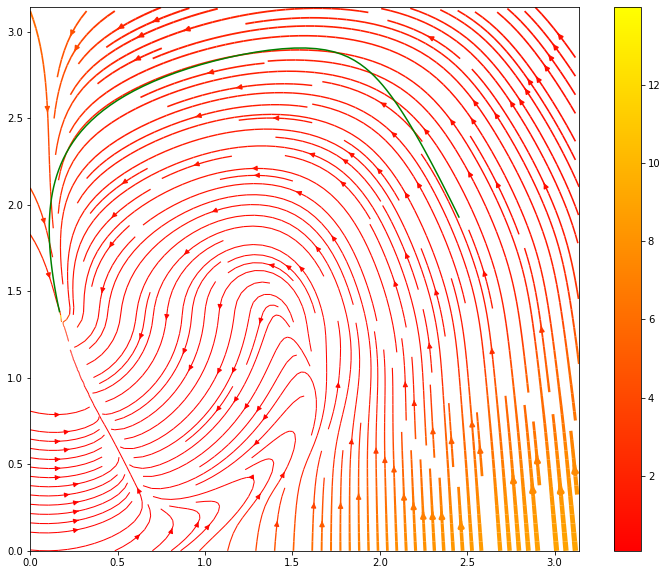

In [6]:
plt_.plot_f('fplot.png', 2, 0.5, 1, quiver = False, streamplot = True)

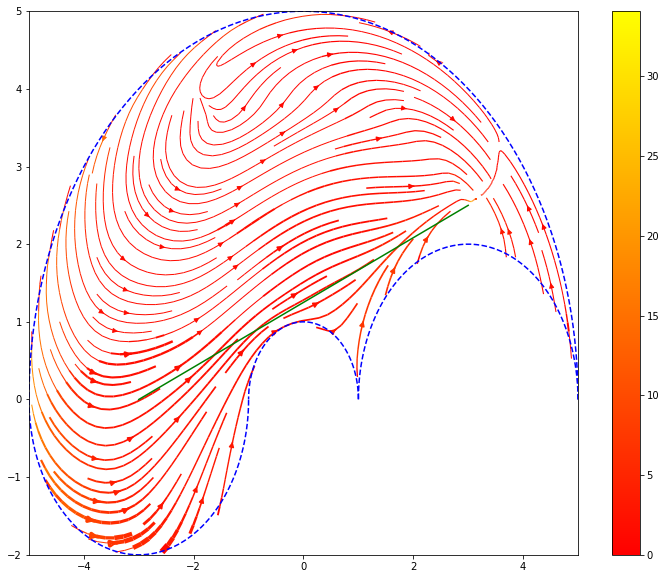

<Figure size 835.92x504 with 0 Axes>

In [7]:
plt_.plot_f_taskspace('task_plot.png', robot, 2, 0.5, 1, quiver = False, streamplot = True)

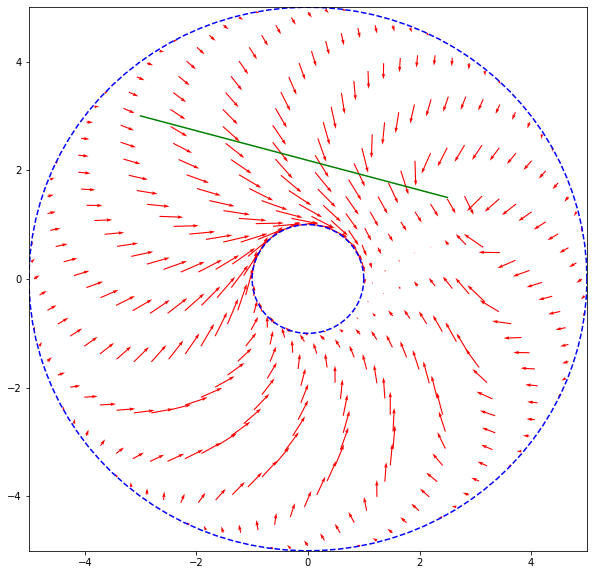

In [22]:
plt_.cal_f()
fnumpy = plt_.f_total.detach()
#xtraj = robot.task_trajectory(robot.xinit, robot.xfinal, robot.T, robot.delta, robot.num_timesteps)
theta = np.linspace(0,2*math.pi,num = 100)
x_r1 = (l1-l2)*np.cos(theta)
y_r1 = (l1-l2)*np.sin(theta)
x_r2 = (l1+l2)*np.cos(theta)
y_r2 = (l1+l2)*np.sin(theta)
if (l1-l2)>0:
    plt.plot(x_r1,y_r1,'--b')
plt.plot(x_r2,y_r2,'--b')
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(robot.xinit.numpy(),robot.xfinal.numpy(),'g')
#x1_mesh,x2_mesh = torch.meshgrid(xtraj[0,:],xtraj[1,:])
#widths = 0.002
plt.axis([-(l1+l2), (l1+l2), -(l1+l2), (l1+l2)])
#plt.quiver(xtraj[0,:],xtraj[1,:],x_dot[0,:],x_dot[1,:],width=0.003)
#plt.savefig('x.png',dpi = 200)

q1_mesh = plt_.q1_mesh
q2_mesh = plt_.q2_mesh
x1_mesh = np.zeros(q1_mesh.shape)
x2_mesh = np.zeros(q1_mesh.shape)
x_1_dot = np.zeros(q1_mesh.shape)
x_2_dot = np.zeros(q1_mesh.shape)

for i in range(q1_mesh.shape[0]):
    for j in range(q1_mesh.shape[1]):
        temp = robot.forward_kinematics([q1_mesh[i,j],q2_mesh[i,j]])
        temp2 = np.matmul(robot.get_jacobian([q1_mesh[i,j],q2_mesh[i,j]]),fnumpy[i,j,:])
        x1_mesh[i,j] = temp[0]
        x2_mesh[i,j] = temp[1]
        x_1_dot[i,j] = temp2[0]
        x_2_dot[i,j] = temp2[1]

plt.quiver(x1_mesh,x2_mesh,x_1_dot,x_2_dot,color = 'r',width=0.002)
#plt.streamplot(x1_mesh,x2_mesh,x_1_dot,x_2_dot,density = 3)#,
                       #color = np.log(x_1_dot*x_1_dot+x_2_dot*x_2_dot))

In [15]:
q1_mesh = plt_.q1_mesh
q2_mesh = plt_.q2_mesh
x1_mesh = np.zeros(q1_mesh.shape)
x2_mseh = np.zeros(q2_mesh.shape)

for i in range(q1_mesh.shape[0]):
    for j in range(q1_mesh.shape[1]):
        temp = robot.forward_kinematics([q1_mesh[i,j],q2_mesh[i,j]])
        x1_mesh[i,j] = temp[0]
        x2_mseh[i,j] = temp[1]
        


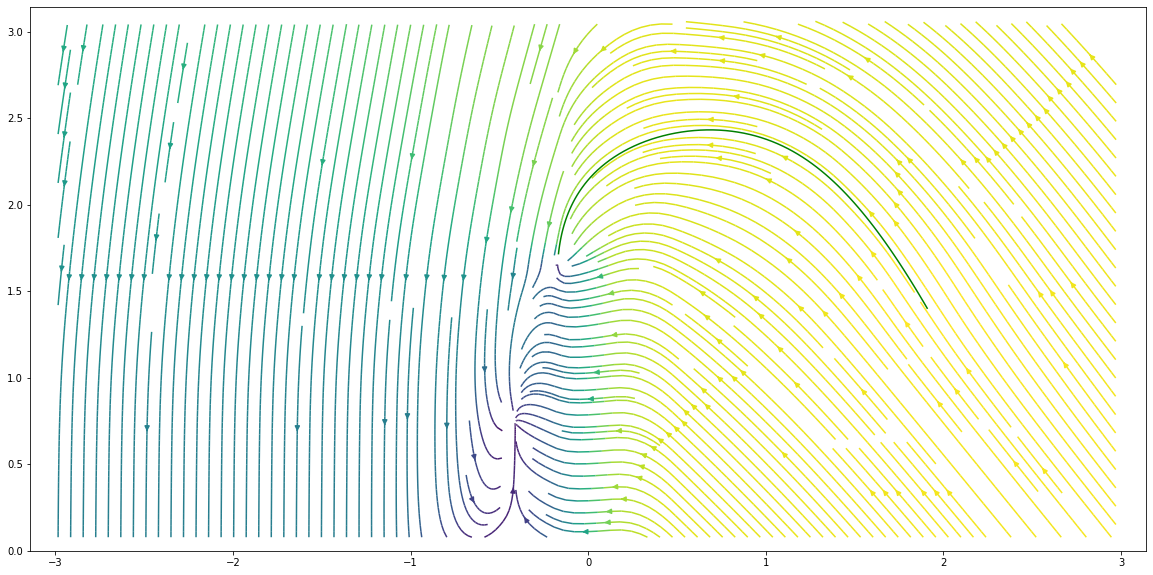

In [7]:
plt_.plot_fhat('fhatplot.png', quiver = False, streamplot = True)

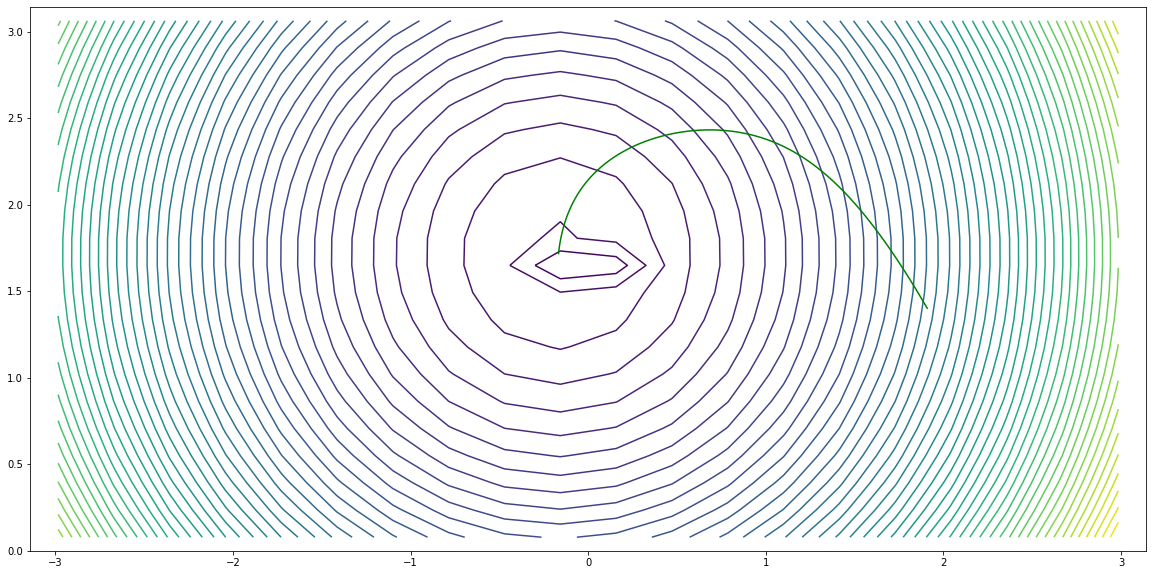

In [8]:
plt_.plot_V('Vplot.png')